# Frank Wolfe

### Milad Jalali, Alireza Naderi, Mohamad amin Mohammadi

In this homework we explore frank wolfe algorithm, we saw how this algorithm avoids a projection step in favor of a sometimes cheaper optimization over the constrained set. in this homework we illustrate this idea in solving lasso regression. we use this method to on a famous kaggle dataset namely housing prices. lasso regression can be formulated as following optimization problem. Given a data matrix $A \in \mathbb{R}^{n \times d}$ and a target variable $b \in \mathbb{R}^{n}$ where n is the size of dataset and d is the number of features:
$$\operatorname{minimize}_{x}\frac{1}{2}\|A x-b\|_{2}^{2} \text { st }\|x\|_{1} \leq \tau$$

In [513]:
import argparse
import os
import pickle
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from numpy.linalg import solve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

np.random.seed(1337)

def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys)

## Frank Wolfe & Oracles

in frank wolfe algorithm there is one important linear optimization step in every iteration. in step k of the algorithm we have.
$$\overline{x_k} = \underset{x \in \mathcal{C}}{\operatorname{argmin}} f(x_k) + \langle {\nabla f(x_k),x-x_k} \rangle$$
$$x_{k+1} = x_k + \alpha (\overline{x_k}-x_k)$$
note that:
$$\overline{x_k} = \underset{x \in \mathcal{C}}{\operatorname{argmin}} \langle {\nabla f(x_k),x} \rangle$$
in case of lasso regression $\mathcal{C} = \|x\|_{1} \leq \tau$. note that in this case $\mathcal{C}$ is a simplex and we are optimizing a linear function on it, so we only need to check vertices for the optimal soloution. so in this case we only need to check $[\pm \tau e_i]_{i=1}^{n}$. which is done in linear time.

In [273]:
def oracle_l1(tau, x, grad):
    x_star = [[0]]*x.shape[0]
    gradient = grad(x)
    
    if np.all(gradient==0) == True:
        return x_star
    
    else:
        argmax = np.argmax(np.abs(gradient))
        x_star[argmax] = [tau * np.sign(-gradient[argmax,0])]
        return x_star

In [274]:
def oracle_l2(tau, x, grad):
    x_star = tau*grad(x)/np.linalg.norm(grad(x),2)
    return x_star

In [275]:
def frank_wolfe(init, steps, oracle):
    xs = [init]
    
    for step in steps:
        xs.append(xs[-1] + step*(oracle(xs[-1])-xs[-1]))        
    return xs

In [7]:
def my_function(A, b, x):
    z = A.dot(x)-b
    return 0.5*z.T.dot(z)[0][0]

def my_function_gradient(A, b, x):
    return A.T.dot(A.dot(x)-b)

## Least Squares
in this part lasso algorithm is implemented using frank-wolfe algorithm

In [506]:
class LeastSquares:
    
    def __init__(self, tau):
        self.tau = tau
        
    def fit(self, X, y):
        A = X
        b = y
        n, d = A.shape
        a = np.array([[1]]*n)
        A_new=np.append(A, a, axis=1)
        
        grad = lambda x: my_function_gradient(A_new, b, x)
        #oracle = lambda x: my_function_gradient(A_new, b, x)
        #oracle = lambda x: oracle_l1(n*self.tau, x, grad)
        oracle = lambda x: oracle_l1(self.tau, x, grad)
        #oracle = lambda x: oracle_l2(self.tau, x, grad)
        x0 = np.random.normal(0, 1, (d+1,1))
        steps = [2./(k+2.) for k in range(1, 10000)]

        xs = frank_wolfe(x0, steps, oracle)        
        self.w = xs[-1]
        #self.w = solve(X.T@X, X.T@y)

    def predict(self, X):
        n, d = X.shape
        a = np.array([[1]]*n)
        X_new=np.append(X, a, axis=1)
        return X_new@self.w
    
    def score(self, X, y):
        return r2_score(y,self.predict(X))

In [277]:
url_amazon = "https://www.amazon.com/dp/%s"

def load_dataset(filename):
    with open(os.path.join('.','data',filename), 'rb') as f:
        return pickle.load(f)

In [16]:
data = load_dataset("basisData.pkl")
X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']

# Fit least-squares model
model = LeastSquares(1)
model.fit(X,y)

#utils.test_and_plot(model,X,y,Xtest,ytest,title="Least Squares, no bias",filename="least_squares_with_bias.pdf")

In [279]:
def test_and_plot(model,X,y,Xtest=None,ytest=None,title=None):

    # Compute training error
    trainError = mean_squared_error(model.predict(X), y)
    print("Training error = %.1f" % trainError)

    # Compute test error
    if Xtest is not None and ytest is not None:
        testError = mean_squared_error(model.predict(Xtest), ytest)
        print("Test error     = %.1f" % testError)

    # Plot model
    plt.figure()
    plt.plot(X,y,'b.')

    # Choose points to evaluate the function
    Xgrid = np.linspace(np.min(X),np.max(X),1000)[:,None]
    ygrid = model.predict(Xgrid)
    plt.plot(Xgrid, ygrid, 'g')

    if title is not None:
        plt.title(title)

In [280]:
def test_and_report(model,X,y,Xtest=None,ytest=None):

    # Compute training error
    trainError = mean_squared_error(model.predict(X), y)

    # Compute test error
    if Xtest is not None and ytest is not None:        
        testError = mean_squared_error(model.predict(Xtest), ytest)

    return trainError, testError

# Experiment
in this part we apply our algorithm to famous kaggle house prices dataset. since we don't have any test dataset we use 80% of training dataset to train our model and use the rest for testing. in order to find the optimal value of the hyperparameter we use 10-fold cross validation on Coefficient of determination ($R^2$). we sample 100 points from a pre determined range of values and plot coresponding values of $R^2$ and chose the optimal value among this sample points. note that we may have to change our range of values a few times  

In [292]:
from house_data_clearing import read_data, clear_data

train, test = read_data()
X, X_sub, y = clear_data(train, test)
X = X.values
y = np.atleast_2d(y.values).T

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=42)

# Sklearn 
we use Sklearn implementation of Lasso as our benchmark. note that Sklearn solves a slighlty diffrent but equivalient problem. sklearn solves the following problem:
$$
\operatorname{minimize}_{x} \frac{1}{2} \|A x-b\|_{2}^{2}+\alpha\|x\|_{1}
$$
but we aim to solve this problem:
$$\operatorname{minimize}_{x}\frac{1}{2}\|A x-b\|_{2}^{2} \text { st }\|x\|_{1} \leq \tau$$
note that the two problem are equivalent and there is one to one correspondence between the values of $\tau$ and $\alpha$

In [346]:
def Cross_KFold(model, X, y):
    scores = []
    cv = KFold(n_splits=10, random_state=42, shuffle=False)
    for train_index, test_index in cv.split(X_train):
        #print("Train Index: ", train_index, "\n")
        #print("Test Index: ", test_index)

    #     Xtrain, Xtest, ytrain, ytest = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
    #     model.fit(Xtrain, ytrain)
    #     scores.append(model.score(Xtest, ytest))
        Xtrain, Xtest, ytrain, ytest = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(Xtrain, ytrain)
        scores.append(model.score(Xtest,ytest)) 
    return np.mean(scores)

In [3]:
import random
samples = sorted(random.sample(range(1,5000),10))

In [4]:
samples

[22, 723, 2491, 2524, 3421, 3685, 4032, 4172, 4318, 4382]

In [516]:
ext_scores = []
samples = sorted(np.random.uniform(0,1,100))
for a in samples:
    model = Lasso(alpha=a)
    score = Cross_KFold(model, X_train, y_train)
    ext_scores.append((a, score))

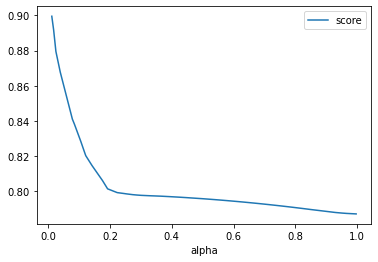

In [517]:
df = pd.DataFrame(ext_scores, columns=['alpha', 'score'])
df.plot.line(x='alpha', y='score')

In [518]:
ext_scores = []
samples = sorted(np.random.uniform(0,1e-1,100))
for a in samples:
    model = Lasso(alpha=a)
    score = Cross_KFold(model, X_train, y_train)
    ext_scores.append((a, score))

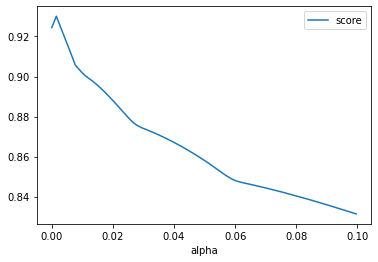

In [519]:
df = pd.DataFrame(ext_scores, columns=['alpha', 'score'])
df.plot.line(x='alpha', y='score')

In [531]:
ext_scores = []
samples = sorted(np.random.uniform(0,1e-3,100))
for a in samples:
    model = Lasso(alpha=a)
    score = Cross_KFold(model, X_train, y_train)
    ext_scores.append((a, score))

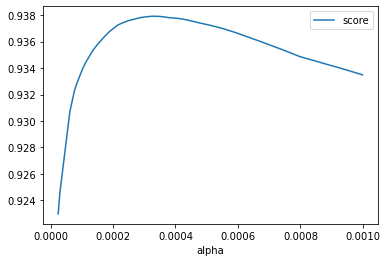

In [532]:
df = pd.DataFrame(ext_scores, columns=['alpha', 'score'])
df.plot.line(x='alpha', y='score')

In [533]:
alpha_star = df['alpha'][np.argmax(df['score'])]
model = Lasso(alpha_star)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.9192727000235505

In [534]:
mean_squared_error(model.predict(X_test), y_test)

0.01254107577485108

# Our Implementation

In [511]:
scores = []
samples = sorted(np.random.uniform(0,1,100))
for tau in samples:
    model = LeastSquares(tau)
    score = Cross_KFold(model, X_train, y_train)
    scores.append((tau, score))

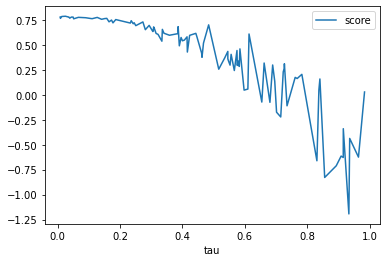

In [512]:
df = pd.DataFrame(scores, columns=['tau', 'score'])
df.plot.line(x='tau', y='score')

In [524]:
scores = []
samples = sorted(np.random.uniform(0.005,.05,10))
for tau in samples:
    model = LeastSquares(tau)
    score = Cross_KFold(model, X_train, y_train)
    scores.append((tau, score))

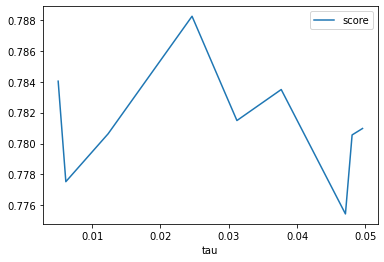

In [527]:
df = pd.DataFrame(scores, columns=['tau', 'score'])
df.plot.line(x='tau', y='score')

In [528]:
tau_star = df['tau'][np.argmax(df['score'])]
model = LeastSquares(tau_star)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.8010142212540888

In [529]:
mean_squared_error(model.predict(X_test), y_test)

0.030912661888831103